<a href="https://www.kaggle.com/code/faizanaliabdulali/skeleton-matching?scriptVersionId=183301116" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [61]:
!pip install rembg==2.0.56 -q

In [62]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

## Image Pipeline

In [63]:
def plot_image(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()

class ImageProcessor:
    """Processes images by removing backgrounds, enhancing contrast, and aligning them"""

    def __init__(self, model_name="isnet-general-use"):
        self.session = new_session(model_name)

    def contrast_using_dynamic_gamma(self, image):
        """Adjusts image contrast based on mean intensity"""
        mean_intensity = np.mean(image)
        gamma = 2.5 if mean_intensity < 50 else 2.0 if mean_intensity < 100 else 1.5 if mean_intensity < 150 else 1.7 if mean_intensity < 200 else 0.5
        table = np.array([(i / 255) ** (1 / gamma) * 255 for i in range(256)], dtype="uint8")
        return cv2.LUT(image, table), gamma

    def get_grayed_image(self, image):
        """Converts image to grayscale and adjusts its contrast"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return self.contrast_using_dynamic_gamma(gray_image)[0]

    def remove_bg(self, input_img, only_mask=False):
        """Removes the background of the image using the model session"""
        return remove(data=input_img, only_mask=only_mask, session=self.session)

    def get_skeleton_and_contour(self, image):
        """Extracts the largest contour and creates a skeleton image"""
        gray_mask = np.array(self.remove_bg(image, only_mask=True))
        _, bin_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        largest_contour = max(contours, key=cv2.contourArea)
        skeleton = np.zeros_like(image, dtype=np.uint8)
        thickness = (skeleton.shape[0] + skeleton.shape[1]) // 200
        cv2.drawContours(skeleton, [largest_contour], -1, 255, thickness)
        
        return skeleton, largest_contour

    def straighten_and_crop(self, image, contour):
        """Crops the image to the bounding box of the largest contour and straightens it"""
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]

        orientation = 'vertical' if h > w else 'horizontal'
        points = {
            'leftmost': tuple(contour[contour[:, :, 0].argmin()][0]),
            'rightmost': tuple(contour[contour[:, :, 0].argmax()][0]),
            'topmost': tuple(contour[contour[:, :, 1].argmin()][0]),
            'bottommost': tuple(contour[contour[:, :, 1].argmax()][0])
        }

        if orientation == 'vertical':
            center = ((points['leftmost'][0] + points['rightmost'][0]) // 2, 
                      (points['leftmost'][1] + points['rightmost'][1]) // 2)
            endpoint = points['topmost']
        else:
            center = ((points['topmost'][0] + points['bottommost'][0]) // 2, 
                      (points['topmost'][1] + points['bottommost'][1]) // 2)
            endpoint = points['rightmost']

        angle = math.degrees(math.atan2(endpoint[1] - center[1], endpoint[0] - center[0]))
        h, w = cropped_image.shape[:2]
        new_w = int(h * abs(math.sin(math.radians(angle))) + w * abs(math.cos(math.radians(angle))))
        new_h = int(h * abs(math.cos(math.radians(angle))) + w * abs(math.sin(math.radians(angle))))

        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        M[0, 2] += (new_w / 2) - (w // 2)
        M[1, 2] += (new_h / 2) - (h // 2)

        return cv2.warpAffine(cropped_image, M, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    def resize_with_padding(self, image):
        """Resizes the image to 256x256 with 12 pixels of padding"""
        h, w = image.shape[:2]
        size = max(h, w)
        square_image = np.zeros((size, size), dtype=np.uint8)
        if h > w:
            offset = (h - w) // 2
            square_image[:, offset:offset+w] = image
        else:
            offset = (w - h) // 2
            square_image[offset:offset+h, :] = image

        resized_image = cv2.resize(square_image, (232, 232))
        return cv2.copyMakeBorder(resized_image, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    def set_contour_thickness(self, binary_image, line_thickness):
        """Sets the thickness of the outlined object"""
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)

        contour_image = np.zeros_like(binary_image)
        cv2.drawContours(contour_image, [largest_contour], -1, 255, thickness=line_thickness)

        return contour_image

    def process(self, rgb_image):
        """Complete processing pipeline: graying, skeletonizing, straightening, cropping, resizing, and displaying the image"""
        gray_image = self.get_grayed_image(np.array(rgb_image))
        skeleton, largest_contour = self.get_skeleton_and_contour(gray_image)
        straightened_cropped_image = self.straighten_and_crop(skeleton, largest_contour)
        resized_image = self.resize_with_padding(straightened_cropped_image)
        final_image = self.set_contour_thickness(resized_image, 2)
        return final_image

## Loading and Processing

In [64]:
filepaths, images = [], []
BASE_PATH = '/kaggle/input/key-images/'

# for filename in os.listdir(BASE_PATH):
#     if filename[0].isdigit():
#         path = os.path.join(BASE_PATH, filename)
#         filepaths.append(path)
        
# filepaths.sort()
# filepaths = filepaths[9:]

# [Case]: Real images filepaths
filepaths = [
    f"{BASE_PATH}dark-contrast/1717401672.png",        # Key-2
    f"{BASE_PATH}dark-contrast/1717401055.png",        # Key-1
    f"{BASE_PATH}non-white-background/1717759168.png", # Key-1
    f"{BASE_PATH}dark-contrast/1717666406.png",        # Key-5
    f"{BASE_PATH}dark-contrast/1717681430.png",        # Key-5
    f"{BASE_PATH}dark-contrast/1717666433.png",        # Key-3
    f"{BASE_PATH}dark-contrast/1717666074.png",        # Key-3
    f"{BASE_PATH}dark-contrast/1717681361.png",        # Key-3
    f"{BASE_PATH}dark-contrast/1717666108.png",        # Key-4
    f"{BASE_PATH}dark-contrast/1717681457.png",        # Key-4
    f"{BASE_PATH}dark-contrast/1717681630.png",        # Key-4
]

for filepath in filepaths:
    images.append(cv2.imread(filepath))

In [65]:
processed = []
processor = ImageProcessor()

for image in tqdm(images, desc='Processing images', unit='image'):
    processed_image = processor.process(image)
    processed.append(processed_image)

Processing images: 100%|██████████| 11/11 [00:28<00:00,  2.64s/image]


## Cosine Similarity

In [66]:
def plot_cosine_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]
            confusion_matrix[i, j] = cosine_sim

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_cosine_similarity_score(processed, range(len(processed)))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.215361,0.320595,0.268910,0.116238,0.304873,0.365171,0.318333,0.328400,0.300900,0.207702
1,0.215361,1.000000,0.372722,0.142882,0.078921,0.176245,0.203567,0.124868,0.127998,0.147728,0.159147
2,0.320595,0.372722,1.000000,0.169071,0.129979,0.344628,0.375990,0.232708,0.271066,0.300115,0.272350
3,0.268910,0.142882,0.169071,1.000000,0.198385,0.199669,0.197201,0.170876,0.157659,0.148507,0.105034
4,0.116238,0.078921,0.129979,0.198385,1.000000,0.103996,0.075647,0.153523,0.147080,0.122273,0.152173
5,0.304873,0.176245,0.344628,0.199669,0.103996,1.000000,0.507390,0.397354,0.280153,0.470084,0.269850
6,0.365171,0.203567,0.375990,0.197201,0.075647,0.507390,1.000000,0.237445,0.205038,0.328609,0.190618
7,0.318333,0.124868,0.232708,0.170876,0.153523,0.397354,0.237445,1.000000,0.438491,0.472139,0.262736
8,0.328400,0.127998,0.271066,0.157659,0.147080,0.280153,0.205038,0.438491,1.000000,0.607763,0.447276
9,0.300900,0.147728,0.300115,0.148507,0.122273,0.470084,0.328609,0.472139,0.607763,1.000000,0.489401


## Hu Moments

In [67]:
def plot_hu_moments_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            
             # Calculate moments
            moments1 = cv2.moments(images_data[i])
            moments2 = cv2.moments(images_data[j])

            # Calculate Hu moments
            huMoments1 = cv2.HuMoments(moments1).flatten()
            huMoments2 = cv2.HuMoments(moments2).flatten()

            # Compare Hu moments using Euclidean distance
            distance = np.linalg.norm(huMoments1 - huMoments2)

            confusion_matrix[i, j] = round(1 - distance, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_hu_moments_score(processed, range(len(processed)))

,0,1,2,3,4,5,6,7,8,9,10
0,1.0000,0.9996,0.9989,0.9992,1.0000,0.9993,0.9995,0.9992,0.9989,0.9989,0.9987
1,0.9996,1.0000,0.9992,0.9988,0.9996,0.9997,0.9999,0.9996,0.9993,0.9993,0.9990
2,0.9989,0.9992,1.0000,0.9981,0.9988,0.9995,0.9993,0.9997,0.9999,0.9999,0.9998
3,0.9992,0.9988,0.9981,1.0000,0.9992,0.9985,0.9987,0.9984,0.9981,0.9981,0.9979
4,1.0000,0.9996,0.9988,0.9992,1.0000,0.9993,0.9995,0.9991,0.9989,0.9989,0.9986
5,0.9993,0.9997,0.9995,0.9985,0.9993,1.0000,0.9998,0.9999,0.9996,0.9996,0.9993
6,0.9995,0.9999,0.9993,0.9987,0.9995,0.9998,1.0000,0.9997,0.9994,0.9994,0.9991
7,0.9992,0.9996,0.9997,0.9984,0.9991,0.9999,0.9997,1.0000,0.9997,0.9997,0.9995
8,0.9989,0.9993,0.9999,0.9981,0.9989,0.9996,0.9994,0.9997,1.0000,1.0000,0.9997
9,0.9989,0.9993,0.9999,0.9981,0.9989,0.9996,0.9994,0.9997,1.0000,1.0000,0.9997


## Rotation Testing

In [68]:
# import math
# import random

# def random_rotate_image(image, rand_range):
#     height, width = image.shape[:2]

#     # Generate a random rotation angle between -30 and 30 degrees
#     angle = random.uniform(-rand_range, rand_range)

#     # Calculate the rotation matrix
#     center = (width / 2, height / 2)
#     rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

#     # Calculate the sine and cosine of the rotation angle
#     cos_angle = abs(rot_matrix[0, 0])
#     sin_angle = abs(rot_matrix[0, 1])

#     # Compute the new bounding box dimensions
#     new_width = int((height * sin_angle) + (width * cos_angle))
#     new_height = int((height * cos_angle) + (width * sin_angle))

#     # Adjust the rotation matrix to take into account the translation
#     rot_matrix[0, 2] += (new_width / 2) - center[0]
#     rot_matrix[1, 2] += (new_height / 2) - center[1]

#     # Perform the rotation
#     rotated_img = cv2.warpAffine(image, rot_matrix, (new_width, new_height))

#     # Calculate the coordinates for cropping to the original size
#     x = (new_width - width) // 2
#     y = (new_height - height) // 2
#     cropped_img = rotated_img[y:y + height, x:x + width]

#     # Save the output image
#     return cropped_img

# skewed_images = []

# for image in skeletons:
#     skewed = random_rotate_image(image, 5)
#     skewed_images.append(skewed)
#     plt_img(skewed, cmap="gray")

# def plot_skewed_cosine_similarity_score(images_data, index_array):
#     num_images = len(images_data)
#     confusion_matrix = np.zeros((num_images, num_images))

#     for i in range(num_images):
#         for j in range(num_images):
#             flat_img1 = images_data[i].flatten().reshape(1, -1)
#             flat_img2 = images_data[j].flatten().reshape(1, -1)

#             cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

#             confusion_matrix[i, j] = round(cosine_sim, 4)

#     df_confusion_matrix = pd.DataFrame(confusion_matrix, 
#                                        index=index_array, 
#                                        columns=index_array)
#     return df_confusion_matrix

# indexes = [path.split('/')[-1] for path in filepaths]

# plot_cosine_similarity_score(skewed_images, indexes)

## SIFT

In [69]:
# def plot_SIFT_score(images_data, index_array):
#     sift = cv2.SIFT_create()
#     search_params = dict(checks=40)
#     index_params = dict(algorithm=1, trees=5)
#     matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
#     MATCH_RATIO = 0.75
#     all_keypoints = []
#     all_descriptors = []

#     for image in images_data:
#         keypoints, descriptors = sift.detectAndCompute(image, None)
#         all_keypoints.append(keypoints), all_descriptors.append(descriptors)
    
#     num_images = len(images_data)
#     confusion_matrix = np.zeros((num_images, num_images))

#     for i in range(num_images):
#         for j in range(num_images):
#             matches = matcher.knnMatch(all_descriptors[i], all_descriptors[j], k=2)
            
#             good_matches = []
#             for m, n in matches:
#                 if m.distance < MATCH_RATIO * n.distance:
#                     good_matches.append(m)

#             confusion_matrix[i, j] = len(matches) / min(
#                 len(all_descriptors[i]), 
#                 len(all_descriptors[j]),
#             )
            
#             confusion_matrix[i, j] = len(good_matches) / len(all_descriptors[i])

#     df_confusion_matrix = pd.DataFrame(confusion_matrix, 
#                                        index=index_array, 
#                                        columns=index_array)
#     return df_confusion_matrix

# indexes = [path.split('/')[-1] for path in filepaths]
# plot_SIFT_score(skeletons, indexes)

### Image Contour Matching

In [70]:
def compare_images_contour(img1, img2):
    contours1, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours1 and contours2:
        match_score = cv2.matchShapes(contours1[0], contours2[0], cv2.CONTOURS_MATCH_I1, 0.0)
        return 1 - match_score  # Lower score means higher similarity
    return 0

def plot_contours_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):

            similarity = compare_images_contour(images_data[i], images_data[j])

            confusion_matrix[i, j] = similarity

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

In [71]:
indexes = [path.split('/')[-1] for path in filepaths]
plot_contours_similarity_score(processed, range(len(processed)))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.970627,0.872448,0.478815,0.583269,0.954966,0.954817,0.924662,0.793017,0.838230,0.875616
1,0.970627,1.000000,0.859270,0.464289,0.554107,0.936857,0.926545,0.925941,0.806023,0.851408,0.884296
2,0.872448,0.859270,1.000000,0.588694,0.678512,0.829370,0.917631,0.797111,0.674118,0.710678,0.748064
3,0.478815,0.464289,0.588694,1.000000,0.895319,0.435738,0.523998,0.403478,0.284918,0.317045,0.354431
4,0.583269,0.554107,0.678512,0.895319,1.000000,0.540419,0.627562,0.508159,0.385824,0.421727,0.459112
5,0.954966,0.936857,0.829370,0.435738,0.540419,1.000000,0.911740,0.967740,0.831212,0.881308,0.918694
6,0.954817,0.926545,0.917631,0.523998,0.627562,0.911740,1.000000,0.879480,0.749177,0.793047,0.830433
7,0.924662,0.925941,0.797111,0.403478,0.508159,0.967740,0.879480,1.000000,0.861176,0.913568,0.950953
8,0.793017,0.806023,0.674118,0.284918,0.385824,0.831212,0.749177,0.861176,1.000000,0.943625,0.909086
9,0.838230,0.851408,0.710678,0.317045,0.421727,0.881308,0.793047,0.913568,0.943625,1.000000,0.955695


### ORB (Oriented Fast and Rotation Brief) Matching

In [72]:

def plot_orb_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):

            similarity = compare_images_orb(images_data[i], images_data[j])

            confusion_matrix[i, j] = similarity

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

plot_orb_similarity_score(processed, range(len(processed)))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.373494,0.361446,0.060241,0.024096,0.322581,0.363636,0.358696,0.428571,0.421687,0.400000
1,0.373494,1.000000,0.551282,0.064103,0.025641,0.322581,0.295455,0.304348,0.452381,0.419753,0.400000
2,0.361446,0.551282,1.000000,0.066667,0.026667,0.247312,0.261364,0.304348,0.345238,0.382716,0.284211
3,0.060241,0.064103,0.066667,1.000000,0.200000,0.064516,0.079545,0.065217,0.095238,0.074074,0.052632
4,0.024096,0.025641,0.026667,0.200000,1.000000,0.021505,0.022727,0.021739,0.023810,0.024691,0.021053
5,0.322581,0.322581,0.247312,0.064516,0.021505,1.000000,0.505376,0.559140,0.333333,0.311828,0.389474
6,0.363636,0.295455,0.261364,0.079545,0.022727,0.505376,1.000000,0.500000,0.250000,0.363636,0.336842
7,0.358696,0.304348,0.304348,0.065217,0.021739,0.559140,0.500000,1.000000,0.326087,0.326087,0.305263
8,0.428571,0.452381,0.345238,0.095238,0.023810,0.333333,0.250000,0.326087,1.000000,0.559524,0.494737
9,0.421687,0.419753,0.382716,0.074074,0.024691,0.311828,0.363636,0.326087,0.559524,1.000000,0.526316


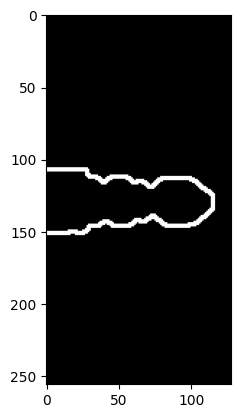

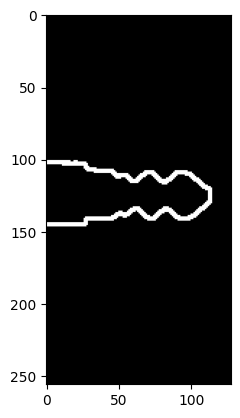

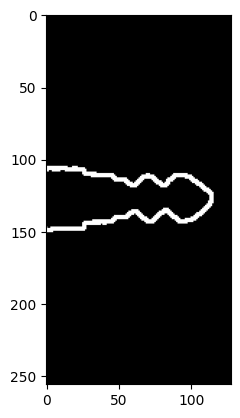

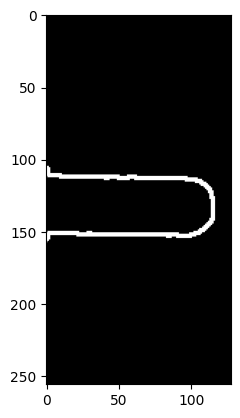

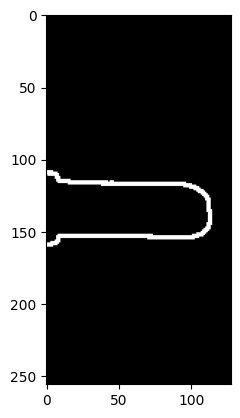

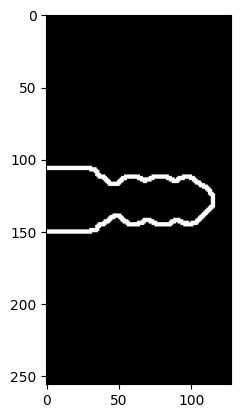

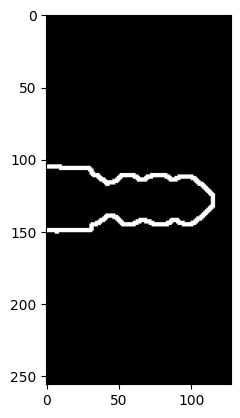

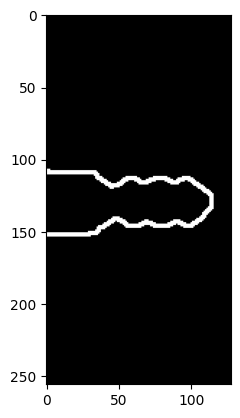

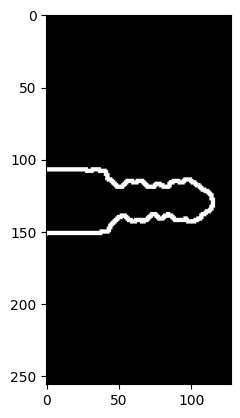

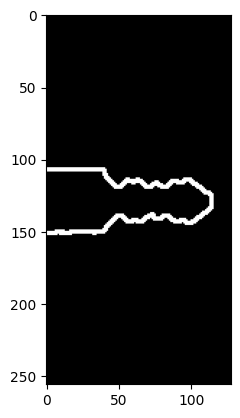

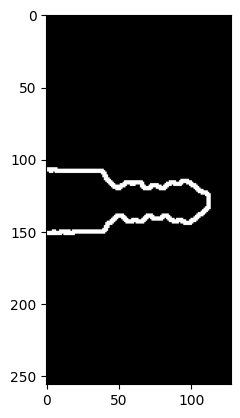

In [73]:
for image in processed:
    plot_image(image[:, 128:])